In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import glob
import ujson as json

import torch


from tqdm import tqdm
import numpy as np
from safetensors import safe_open
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator
# Set font globally to Times New Roman
plt.rcParams['font.family'] = 'DejaVu Serif'
fontsize = 19

### Đo khả năng flos, common loss, perlexity khi train model per 10 % /332k data

In [13]:

percent_data = [
#  'checkpoint-7830',
#  'checkpoint-15660',
#  'checkpoint-23490',
#  'checkpoint-31320',
#  'checkpoint-39148'

 'checkpoint-4159',
 'checkpoint-8318',
 'checkpoint-12477',
 'checkpoint-16636',
 'checkpoint-20791'
]



benchmarks =[
    'ai2d',
    "gqa",
    'mmbench_en_dev',
    'textvqa_val',
    'ocrbench',
    'mmmu_val',
 'mmstar',
 'mme',
 'mmerealworld_lite',
 'pope',
 'hallusion_bench_image',
 'mathvista_testmini'
 ]
benchmarks_selected =[
    'ai2d',
    "gqa",
    'mmbench_en_dev',
    'textvqa_val',
    'ocrbench',
    'mmmu_val',
 'mmstar',
 'mme',
 'mmerealworld_lite',
 'pope',
 'hallusion_bench_image',
 'mathvista_testmini'
 ]


In [14]:

with open("/cm/shared/anonymous_h100/LibMoE/evaluate/analysis/results/result_metric_libmoev2_665k.json", "r") as f:
    results = json.load(f)
    
# check_miss_results(results)

In [15]:
missing = []
for moe_method, logs in results.items():
    for bench in benchmarks_selected:
        for i in percent_data:
            try:
                x =  logs[bench][i]
            except:
                missing.append(f"{moe_method}/{bench}/{i}")


In [16]:
missing

[]

In [17]:
results.keys()

dict_keys(['Full_smoe', 'Full_smoe_share', 'Full_smoe_sigmoidgating', 'Full_smoe_tcmoe', 'Full_xmoe', 'Full_smoe_plus_plus', 'Full_smoe_sharev3'])

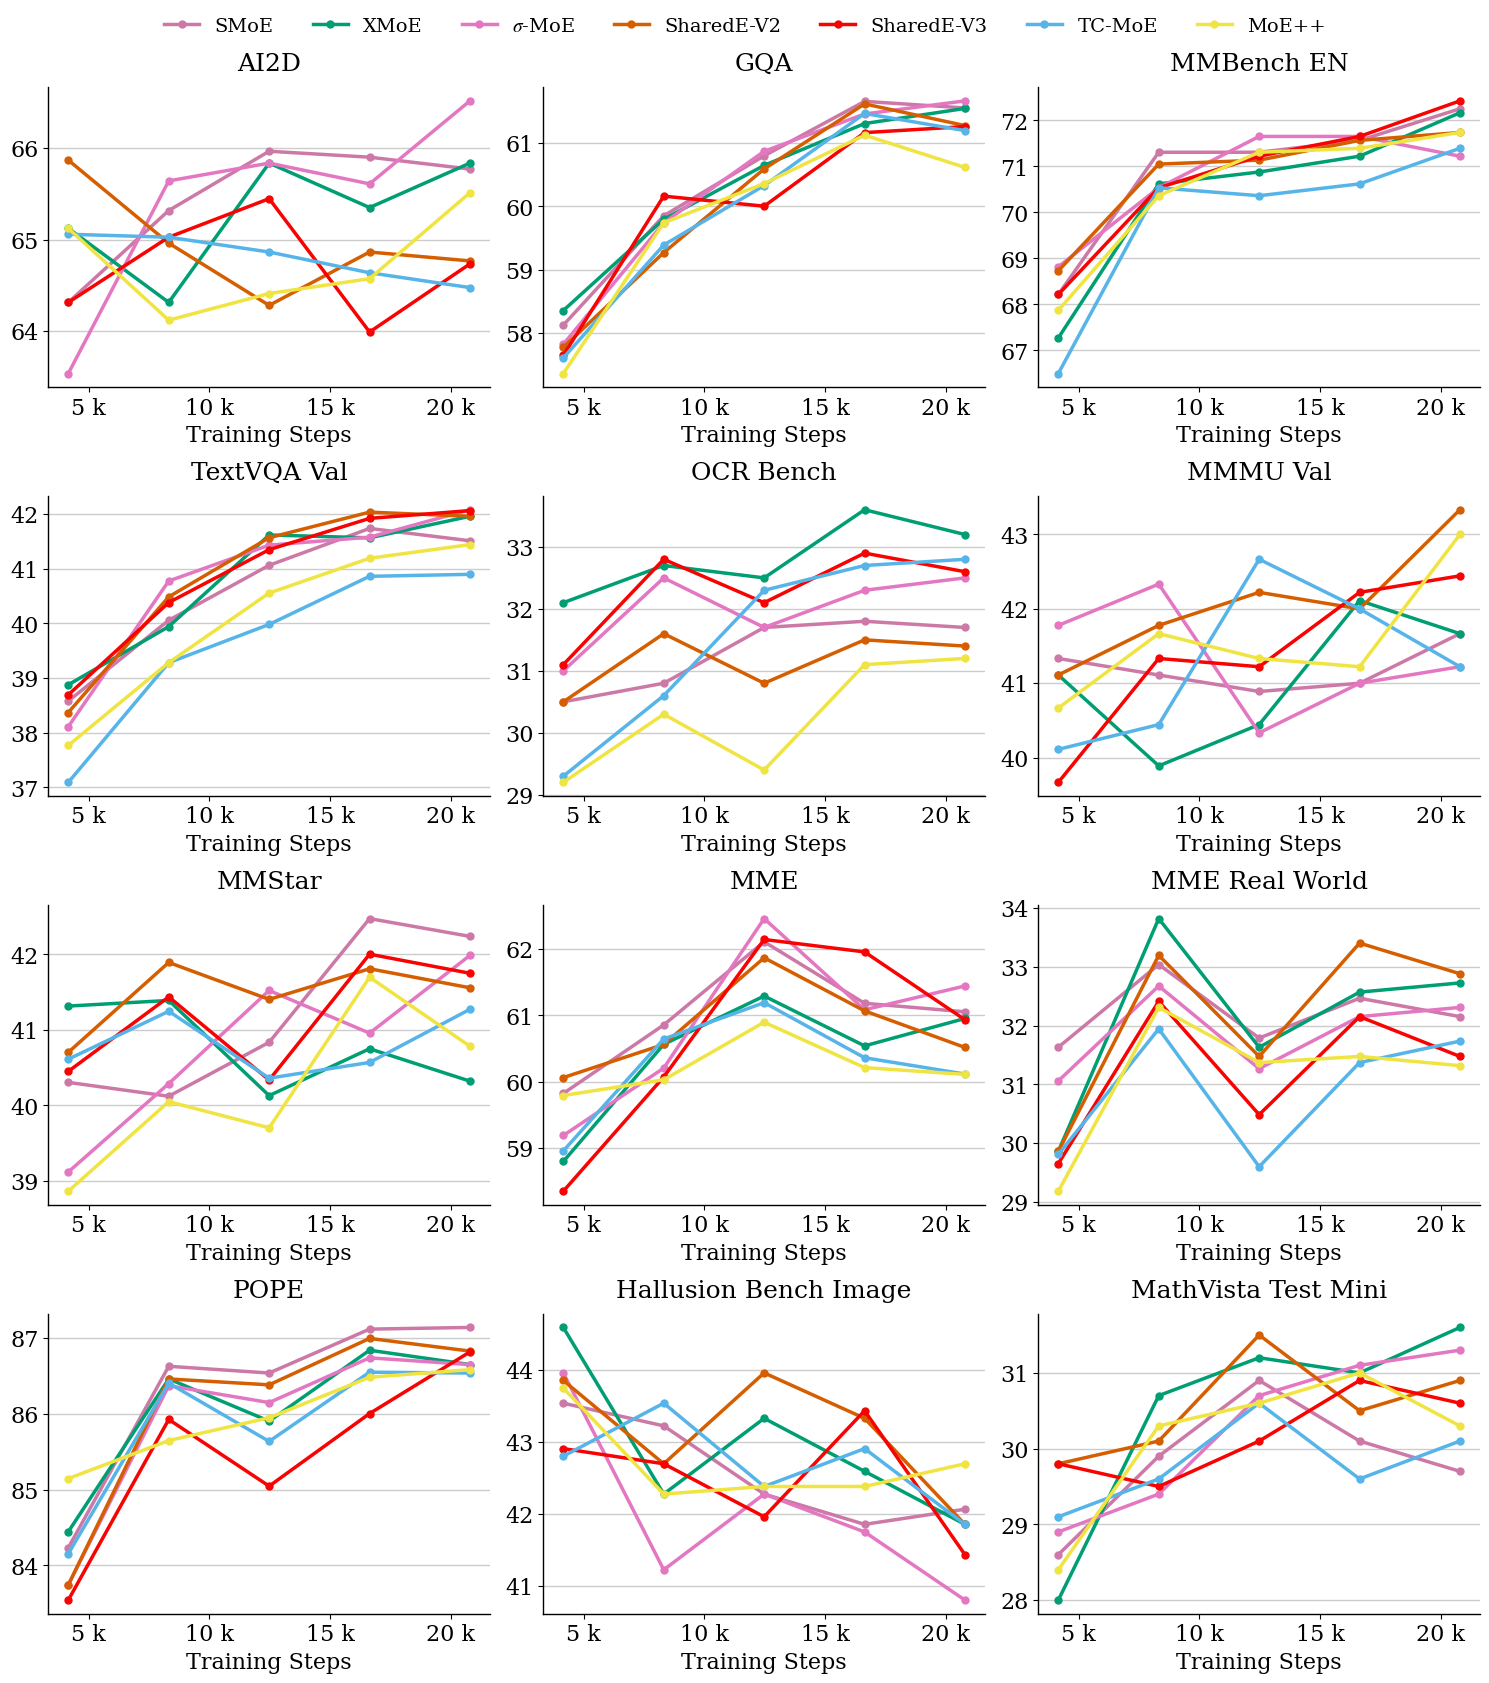

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import EngFormatter, MaxNLocator

# ================== CẤU HÌNH ==================
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['mathtext.fontset'] = 'stix'   # đồng bộ font math

fontsize = 16
steps_fmt = EngFormatter(unit='')  # hiển thị 1k, 10k, 100k...

name_method = {
    'pope': 'POPE',
    'mmstar': "MMStar",
    'gqa': 'GQA',
    'mmbench_en_dev': "MMBench EN",
    'ocrbench': "OCR Bench",
    'scienceqa_img': "SQA IMG",
    'ai2d': "AI2D",
    'mmerealworld_lite': "MME Real World",
    'mathvista_testmini': "MathVista Test Mini",
    'hallusion_bench_image': "Hallusion Bench Image",
    'seedbench_2_plus': "SeedBench2 Plus",
    'mmmu_val': "MMMU Val",
    'mmmu_pro_standard': "MMMU Pro Standard",
    'textvqa_val': "TextVQA Val",
    'infovqa_val': "InfoVQA",
    "mme": "MME",
    'avg': "Average"
}

# YÊU CẦU SẴN: benchmarks_selected (list[str]), percent_data (list), results (dict)
# results[stage][dataset][per] -> { "score": float, "num_input_tokens_seen": int }

# ====== ánh xạ subplot ======
label2id = {}
for i, label in enumerate(benchmarks_selected):
    label2id[label] = i
label2id['avg'] = len(benchmarks_selected)
label2id['avg_rank'] = len(benchmarks_selected) + 1

label2id_stage = {
    'Full_smoe': 0,
    'Full_xmoe': 1,
    'Full_smoe_sigmoidgating': 2,
    'Full_smoe_share': 3,
    'Full_smoe_sharev3': 4,
    'Full_smoe_tcmoe': 5,
    'Full_smoe_plus_plus': 6
}

moe2name = {
    'Full_smoe': "SMoE",
    'Full_xmoe': "XMoE",
    'Full_smoe_sigmoidgating': r"$\sigma$-MoE",
    'Full_smoe_share': "SharedE-V2",
    'Full_smoe_sharev3': "SharedE-V3",
    'Full_smoe_tcmoe': "TC-MoE",
    'Full_smoe_plus_plus': "MoE++"
}

colors = {
    "Full_smoe_share": "#D55E00",
    "Full_smoe_perturbed": "#ff7f0e",
    "Full_smoe": "#CC79A7",
    "Full_competesmoev30": "#000000",
    "Full_xmoe": "#009E73",
    "Full_smoe_sigmoidgating": "#e377c2",
    "Full_smoe_sharev3": "#F80202",
    "Full_smoe_tcmoe": "#56B4E9",
    "Full_smoe_plus_plus": "#F0E442",
}

data_avgs = [
    'ai2d', "gqa", 'mmbench_en_dev', 'textvqa_val', 'ocrbench',
    'mmmu_val', 'mmstar', 'mme', 'mmerealworld_lite', 'pope',
    'hallusion_bench_image', 'mathvista_testmini'
]

arrow_up = ''
arrow_dow = '\u2193'

# ====== figure layout ======
n_cols = 3
n_rows = (len(label2id.keys()) + n_cols - 1) // n_cols
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axs = axs.flatten()

handles_list, labels_list = [], []
stars_to_plot = []
info_avg_rank = {}

# ====== vẽ theo từng stage ======
for stage in label2id_stage.keys():
    if stage not in label2id_stage:
        continue

    # aggregator cho AVG
    avg = {per: {'value': [], 'num_input_tokens_seen': [], "total_flos": []} for per in percent_data}
    info_avg_rank[stage] = {}
    sub_avg_rank = {}

    for data in name_method.keys():
        list_scores = []
        list_steps = []

        for per in percent_data:
            if data == 'avg':
                continue
            try:
                score = results[stage][data][per]["score"]
            except Exception:
                # print(f"missing data: {data}/{per}")
                continue

            # Nếu có sẵn trong results, dùng dòng dưới:
            # num_input_tokens_seen = results[stage][data][per]["num_input_tokens_seen"]
            # Còn không, fallback từ tên per (ví dụ "ckpt-10000" -> 10000):
            num_input_tokens_seen = int(per.split('-')[-1])

            # gom cho Average
            if data in data_avgs:
                avg[per]['value'].append(score)
                avg[per]['num_input_tokens_seen'].append(num_input_tokens_seen)

            # lưu cho từng benchmark
            list_scores.append(score)
            list_steps.append(num_input_tokens_seen)

        if data in benchmarks_selected:
            x_steps_raw = np.array(list_steps, dtype=float)   # dữ liệu thô (steps)
            handle, = axs[label2id[data]].plot(
                x_steps_raw, list_scores, marker='o', linestyle="-",
                label=f'{moe2name[stage]}', color=colors[stage],
                linewidth=2.5, markersize=5
            )
            axs[label2id[data]].set_title(f'{name_method[data]}' + arrow_up,
                                          fontsize=fontsize + 2, pad=12)
            if moe2name[stage] not in labels_list:
                handles_list.append(handle)
                labels_list.append(f'{moe2name[stage]}')

            sub_avg_rank[data] = list_scores

    info_avg_rank[stage] = pd.DataFrame(sub_avg_rank)

    # ---- Average (không scale, dùng EngFormatter) ----
    avg_steps, avg_value = [], []
    for per in percent_data:
        vals_steps = avg[per]['num_input_tokens_seen']
        vals_scores = avg[per]['value']
        avg_steps.append(np.mean(vals_steps) if len(vals_steps) > 0 else np.nan)
        v = np.mean(vals_scores) if len(vals_scores) > 0 else np.nan
        avg_value.append(round(v, 2) if v == v else np.nan)

    avg_steps_raw = np.array(avg_steps, dtype=float)

    axs[label2id['avg']].plot(
        avg_steps_raw, avg_value, marker='o', linestyle="-",
        label=f'{moe2name[stage]}', color=colors[stage],
        linewidth=2.5, markersize=5
    )

    if np.any(~np.isnan(avg_value)):
        max_idx = int(np.nanargmax(avg_value))
        stars_to_plot.append((axs[label2id['avg']],
                              avg_steps_raw[max_idx], avg_value[max_idx],
                              colors[stage]))

# ====== AVG RANKING ======
checkpoints = [i for i in range(5)]
rank_per_checkpoint = pd.DataFrame(index=checkpoints, columns=info_avg_rank.keys())

for checkpoint_idx in range(len(checkpoints)):
    performance_at_checkpoint = {}
    col = None
    for method, results_df in info_avg_rank.items():
        results_without_ppl = results_df.copy()
        col = results_without_ppl.columns
        performance_at_checkpoint[method] = results_without_ppl.iloc[checkpoint_idx].values \
                                            if len(results_without_ppl) else []
    df_checkpoint = pd.DataFrame(performance_at_checkpoint, index=list(col)).T if col is not None else pd.DataFrame()
    df_checkpoint_rank = df_checkpoint.rank(axis=0, method="average", ascending=False)
    ranked_methods = df_checkpoint_rank.mean(axis=1)
    rank_per_checkpoint.iloc[checkpoint_idx] = ranked_methods

rank_per_checkpoint = rank_per_checkpoint.T

# dùng cùng vector X (raw steps) với phần Average ở trên
avg_steps_for_rank = avg_steps_raw

for method in moe2name.keys():
    if method in rank_per_checkpoint.index:
        yvals = rank_per_checkpoint.loc[method].values.tolist()
        if len(yvals) == len(avg_steps_for_rank):
            axs[label2id['avg_rank']].plot(
                avg_steps_for_rank, yvals, marker='o', linestyle="-",
                label=f'{moe2name[method]}', color=colors[method],
                linewidth=2.5, markersize=5
            )

# ====== trang trí & legend ======
axs[label2id['avg']].set_ylabel("Average Accuracy" + arrow_up, fontsize=fontsize, labelpad=5)
axs[label2id['avg_rank']].set_ylabel("Average Rank" + arrow_dow, fontsize=fontsize, labelpad=5)

fig.legend(
    handles=handles_list, labels=labels_list,
    loc='upper center', fontsize=fontsize-2, ncol=7,
    bbox_to_anchor=(0.5, 1.02), frameon=False, handlelength=1.8, borderaxespad=0.6
)

for ax in axs:
    ax.set_xlabel("Training Steps", fontsize=fontsize)
    ax.xaxis.set_major_formatter(steps_fmt)                 # <-- EngFormatter ở đây
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))   # y-ticks là số nguyên

    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.yaxis.grid(True, linestyle='--', color='gray', alpha=0.6)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.spines['left'].set_linewidth(1.)
    ax.spines['bottom'].set_linewidth(1.)
    ax.yaxis.grid(True, which="both", linestyle="-", linewidth=1, alpha=0.4)
# (đẹp hơn) Xóa hẳn:
for ax in axs[-3:]:
    fig.delaxes(ax)
plt.draw()
plt.tight_layout()

# Lưu
plt.savefig("/cm/shared/anonymous_h100/LibMoE/evaluate/analysis/libmoev2/figures/timelearnmetric_steps_all_benchmarks.pdf",
            format='pdf', bbox_inches='tight', dpi=300)
plt.show()


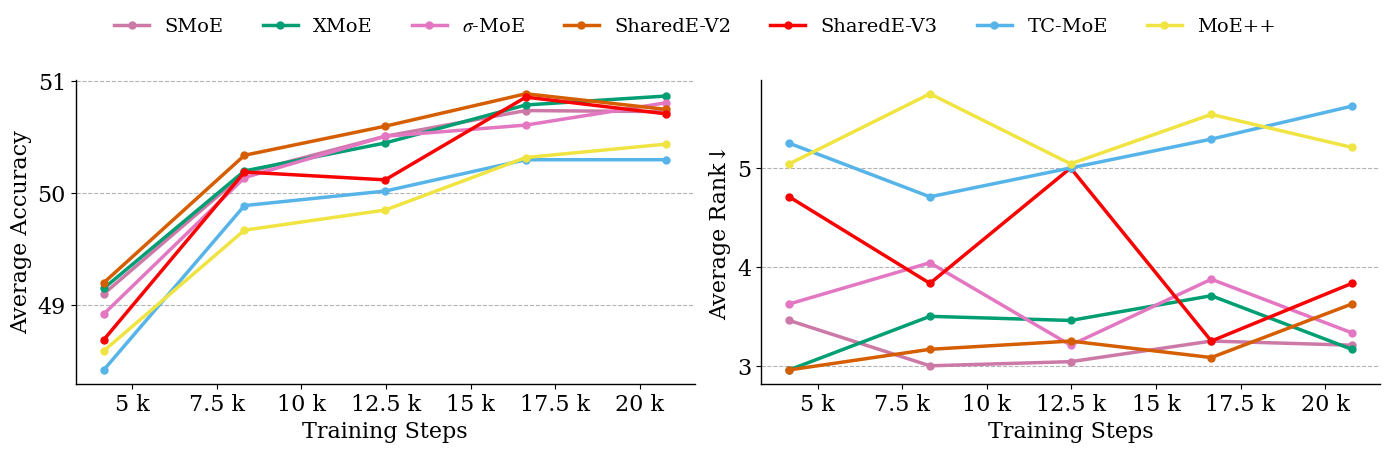

In [19]:
# --- NEW BLOCK: Save compact 1×2 (Average Acc & Average Rank) ---
from matplotlib.ticker import EngFormatter, MaxNLocator

ax_avg  = axs[label2id['avg']]
ax_rank = axs[label2id['avg_rank']]

fig_small, axs_small = plt.subplots(1, 2, figsize=(14, 4))
ax1, ax2 = axs_small

# Clone lines từ figure lớn sang figure nhỏ
for ln in ax_avg.get_lines():
    ax1.plot(
        ln.get_xdata(), ln.get_ydata(),
        marker=ln.get_marker(),
        linestyle=ln.get_linestyle(),
        linewidth=ln.get_linewidth(),
        color=ln.get_color(),
        label=ln.get_label(),
        markersize=getattr(ln, "get_markersize", lambda: 5)()
    )

for ln in ax_rank.get_lines():
    ax2.plot(
        ln.get_xdata(), ln.get_ydata(),
        marker=ln.get_marker(),
        linestyle=ln.get_linestyle(),
        linewidth=ln.get_linewidth(),
        color=ln.get_color(),
        label=ln.get_label(),
        markersize=getattr(ln, "get_markersize", lambda: 5)()
    )

# Nhãn & formatter (EngFormatter) cho trục X
steps_fmt = EngFormatter(unit='')  # hiển thị 1k, 10k, 100k...
ax1.set_xlabel("Training Steps", fontsize=fontsize)
ax2.set_xlabel("Training Steps", fontsize=fontsize)
ax1.xaxis.set_major_formatter(steps_fmt)
ax2.xaxis.set_major_formatter(steps_fmt)

# Y labels
ax1.set_ylabel("Average Accuracy" + arrow_up, fontsize=fontsize)
ax2.set_ylabel("Average Rank" + arrow_dow, fontsize=fontsize)

# Styling đồng nhất
for a in (ax1, ax2):
    a.tick_params(axis='both', which='major', labelsize=fontsize)
    a.yaxis.set_major_locator(MaxNLocator(integer=True))   # y-ticks nguyên
    a.yaxis.grid(True, linestyle='--', color='gray', alpha=0.6)
    a.spines['right'].set_color('none')
    a.spines['top'].set_color('none')
    a.spines['left'].set_linewidth(1.0)
    a.spines['bottom'].set_linewidth(1.0)

# Legend chung (tái dùng handles_list/labels_list từ figure lớn)
fig_small.legend(
    handles_list, labels_list,
    loc='upper center',
    fontsize=fontsize-2,
    ncol=min(7, len(labels_list)),
    bbox_to_anchor=(0.5, 1.15),
    frameon=False, handlelength=1.8, borderaxespad=0.6
)

fig_small.tight_layout()

# Save riêng 2 file (PDF & PNG) cho bản 1×2
out_dir = "/cm/shared/anonymous_h100/LibMoE/evaluate/analysis/libmoev2/figures"
fig_small.savefig(f"{out_dir}/timelearnmetric_avg_2cols.pdf",
                  format="pdf", bbox_inches="tight", dpi=300)
fig_small.savefig(f"{out_dir}/timelearnmetric_avg_2cols.png",
                  format="png", bbox_inches="tight", dpi=300)
# --- END NEW BLOCK ---
